In [3]:
# initial setup
%run "../../../common/0_notebooks_base_setup.py"


/Users/csuarezgurruchaga/Desktop/Digital-House/CLASE_40/dsad_2021/common
default checking
Running command `conda list`... ok
jupyterlab=2.2.6 already installed
pandas=1.1.5 already installed
bokeh=2.2.3 already installed
seaborn=0.11.0 already installed
matplotlib=3.3.2 already installed
ipywidgets=7.5.1 already installed
pytest=6.2.1 already installed
chardet=4.0.0 already installed
psutil=5.7.2 already installed
scipy=1.5.2 already installed
statsmodels=0.12.1 already installed
scikit-learn=0.23.2 already installed
xlrd=2.0.1 already installed
Running command `conda install --yes nltk=3.5.0`... ok
Solving environment: ...working... done

# All requested packages already installed.


unidecode=1.1.1 already installed
pydotplus=2.0.2 already installed
pandas-datareader=0.9.0 already installed
flask=1.1.2 already installed


---

<img src='../../../common/logo_DH.png' align='left' width=35%/>


# Práctica Guiada - Clasificación en datasets desbalanceados

<a id="section_toc"></a> 
## Tabla de Contenidos

[1- Introducción](#section_intro)

[2- Análisis exploratorio del dataset](#section_EDA)

[3- Modelo predictivo: regresión logística](#section_modelo)

[4- Undersampling](#section_undersampling)

[5- Oversampling](#section_oversampling)

[6- Class weighting](#section_class_weighting)


### Introducción

<a id="section_intro"></a> 
[volver a TOC](#section_toc)


El problema de los datasets desbalanceados ocurre cada vez que por algún motivo las clases que se desean identificar se observan con frecuencia muy diferente. Es una situación que se encuentra en una amplia variedad de problemas de Machine Learning como el diagnóstico de enfermedades o la búsqueda de transacciones fraudulentas en un sistema. 

Existen dos grandes enfoques para abordar datasets que se encuentran desbalanceados:

1.  Hacer un resampling de la muestra, para entrenar al algoritmo con proporciones similares de las clases.
2.  Incorporar el desbalance a la función de costos del algoritmo para que tenga incentivos a elegir los parámetros que mejor discriminan la clase minoritaria.




A continuación presentamos un dataset de la empresa americana Lending Club, que se dedica a proveer servicios financieros para distintos segmentos. 

Vamos a utilizar información abierta del portal de la empresa para intentar predecir cuáles de los créditos terminan en default. Para más información sobre el datset pueden ingresar <a href='https://www.lendingclub.com/info/download-data.action'> aquí </a>

### Actualizar scikit-learn e Instalar imbalanced-learn

**Si la primera celda se ejecutó sin errores, omitan esta parte.**

Si no, sigan estas instrucciones para instalar las dependencias necesarias para ejecutar esta notebook.

En esta práctica usaremos la librería imbalanced-learn. La instalamos con la siguiente linea:

!conda install --yes -c conda-forge imbalanced-learn==0.7
 
Pueden tener problemas con versiones de scikitlearn anteriores a 0.23. Entonces:

!conda install scikit-learn==0.23

o

!conda update scikit-learn

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,plot_confusion_matrix,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc

%matplotlib inline

In [5]:
loans = pd.read_csv('../Data/loans.csv',low_memory=False)

In [6]:
loans.head()

,grade,home_ownership,emp_length_num,sub_grade,short_emp,dti,term,purpose,int_rate,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,payment_inc_ratio,bad_loans
0,B,RENT,11,B2,0,27.65,36 months,credit_card,10.65,1,1,83.7,0.00,8.14350,0
1,C,RENT,1,C4,1,1.00,60 months,car,15.27,1,1,9.4,0.00,2.39320,1
2,C,RENT,11,C5,0,8.72,36 months,small_business,15.96,1,1,98.5,0.00,8.25955,0
3,C,RENT,11,C1,0,20.00,36 months,other,13.49,0,1,21.0,16.97,8.27585,0
4,A,RENT,4,A4,0,11.20,36 months,wedding,7.90,1,1,28.3,0.00,5.21533,0



<a id="section_EDA"></a> 
## Análisis exploratorio
[volver a TOC](#section_toc)

#### Balance de la clase

La clase que vamos a intentar predecir es "bad loans" que indica si el préstamo fue pagado a tiempo o no. Observamos que la clase está desbalanceada, la mayoría de los préstamos se pagan a tiempo.

In [7]:
loans['bad_loans'].value_counts(normalize=True)

0    0.811185
1    0.188815
Name: bad_loans, dtype: float64

#### Valores faltantes

Inspeccionamos los valores faltantes

In [8]:
loans.isnull().sum()

grade                    0
home_ownership           0
emp_length_num           0
sub_grade                0
short_emp                0
dti                      0
term                     0
purpose                  0
int_rate                 0
last_delinq_none         0
last_major_derog_none    0
revol_util               0
total_rec_late_fee       0
payment_inc_ratio        4
bad_loans                0
dtype: int64

Eliminamos las entradas nulas

In [9]:
loans.dropna(inplace=True);
loans.reset_index(drop=True,inplace=True)
loans.isnull().sum()

grade                    0
home_ownership           0
emp_length_num           0
sub_grade                0
short_emp                0
dti                      0
term                     0
purpose                  0
int_rate                 0
last_delinq_none         0
last_major_derog_none    0
revol_util               0
total_rec_late_fee       0
payment_inc_ratio        0
bad_loans                0
dtype: int64

<a id="section_modelo"></a> 
## Modelo Predictivo: regresión logística

[volver a TOC](#section_toc)

Vamos a utilizar Regresión Logística para predecir la clase bad_loans. 

In [10]:
loans.shape

(122603, 15)

### Variables dummy

Generamos las variables dummies para los datos categóricos. 

In [11]:
# Generamos las variables dummies para los datos categóricos.
loans_dummy = pd.get_dummies(loans,drop_first=True);

In [12]:
loans_dummy.dtypes

emp_length_num              int64
short_emp                   int64
dti                       float64
int_rate                  float64
last_delinq_none            int64
                           ...   
purpose_moving              uint8
purpose_other               uint8
purpose_small_business      uint8
purpose_vacation            uint8
purpose_wedding             uint8
Length: 65, dtype: object

In [13]:
loans.columns

Index(['grade', 'home_ownership', 'emp_length_num', 'sub_grade', 'short_emp',
       'dti', 'term', 'purpose', 'int_rate', 'last_delinq_none',
       'last_major_derog_none', 'revol_util', 'total_rec_late_fee',
       'payment_inc_ratio', 'bad_loans'],
      dtype='object')

In [14]:
loans.head(3)

,grade,home_ownership,emp_length_num,sub_grade,short_emp,dti,term,purpose,int_rate,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,payment_inc_ratio,bad_loans
0,B,RENT,11,B2,0,27.65,36 months,credit_card,10.65,1,1,83.7,0.0,8.14350,0
1,C,RENT,1,C4,1,1.00,60 months,car,15.27,1,1,9.4,0.0,2.39320,1
2,C,RENT,11,C5,0,8.72,36 months,small_business,15.96,1,1,98.5,0.0,8.25955,0


#### Train test split


In [15]:
X_train, X_test, y_train, y_test\
                            = train_test_split(loans_dummy.drop(['bad_loans'], axis=1),\
                                    loans_dummy['bad_loans'],\
                                    stratify = loans_dummy['bad_loans'],\
                                    random_state=0)

In [16]:
# chequeamos la presencia relativa de cada clase y el tamaño de los datasets
print('Entrenamiento:',X_train.shape)
print('Testeo:',X_test.shape)
print('\nClases train:')
print(y_train.value_counts(normalize=True))
print('\nClases test:')
print(y_test.value_counts(normalize=True))

Entrenamiento: (91952, 64)
Testeo: (30651, 64)

Clases train:
0    0.811184
1    0.188816
Name: bad_loans, dtype: float64

Clases test:
0    0.811164
1    0.188836
Name: bad_loans, dtype: float64


### Regresión logística

La siguiente función implementa una regresión logística optimizando el hiperparámetro de regularización por cross validation.

Luego imprime las métricas principales de evaluación en problemas de clasificación.

In [17]:
def logistic_regression_report(X_train,X_test,y_train,y_test):
    
    scaler=StandardScaler()  
    
    X_train_sc=scaler.fit_transform(X_train) # Estandarizamos los datos     
    X_test_sc=scaler.transform(X_test)
        
    model=LogisticRegressionCV(scoring='f1')
    
    model.fit(X_train_sc,y_train)
    y_pred=model.predict(X_test_sc)
    y_proba=model.predict_proba(X_test_sc)
    
    print(classification_report(y_test,y_pred))
    
    print('Area bajo la curva ROC:',np.round(roc_auc_score(y_test,y_proba[:,1]),4))
    
    precision, recall,threshold=precision_recall_curve(y_test,y_proba[:,1]);

    print('Area bajo la curva Precision-Recall:',np.round(auc(recall,precision),4))

    plot_confusion_matrix(model,X_test_sc,y_test,cmap='Blues');

    return
    

              precision    recall  f1-score   support

           0       0.81      0.99      0.89     24863
           1       0.47      0.02      0.05      5788

    accuracy                           0.81     30651
   macro avg       0.64      0.51      0.47     30651
weighted avg       0.75      0.81      0.73     30651

Area bajo la curva ROC: 0.689
Area bajo la curva Precision-Recall: 0.3252


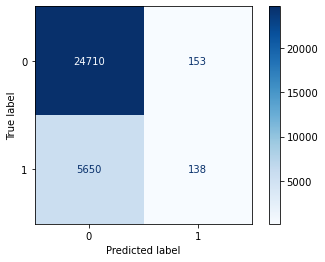

In [18]:
logistic_regression_report(X_train,X_test,y_train,y_test)

Vemos que el modelo tiene una accuracy de 0.81. Los valores de precision y recall nos muestran que el modelo es bueno prediciendo la clase mayoritaria pero es muy malo para la clase minoritaria. 



Vamos a implementar tres posibles soluciones al problema del desbalance de clases:<b> Undersampling, Oversampling, Class weighting</b>

Para resamplear los datos utilizaremos la librería <b>imblearn</b>



<a id="section_undersampling"></a>

## Undersampling

[Volver a TOC](#section_toc)


Una estrategia posible es entrenar un modelo en un subset de datos con clases balanceadas, descartando casos de la clase mayoritaria. Para esto utilizaremos la clase RandomUnderSampler que samplea observaciones de la clase mayoritaria al azar, con o sin reposición.

El hiporparámetro **sampling_strategy** sirve para definir la estrategia de sampleo. La opción 'majority' seleccionará un número de muestras igual al de la clase minoritaria. También se puede pasar un valor numérico entre cero y uno que represnte el ratio entre la clase mayoritaria y la minoritaria.

[Documentación](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.RandomUnderSampler.html)

In [19]:
from imblearn.under_sampling import RandomUnderSampler

undersampler=RandomUnderSampler(sampling_strategy='majority');

X_train_us,y_train_us=undersampler.fit_resample(X_train,y_train);

print('Composición del training set:')
print(y_train_us.value_counts())

print('\nComposición del test set:')
print(y_test.value_counts())


Composición del training set:
1    17362
0    17362
Name: bad_loans, dtype: int64

Composición del test set:
0    24863
1     5788
Name: bad_loans, dtype: int64


              precision    recall  f1-score   support

           0       0.88      0.63      0.74     24863
           1       0.29      0.64      0.40      5788

    accuracy                           0.63     30651
   macro avg       0.59      0.64      0.57     30651
weighted avg       0.77      0.63      0.67     30651

Area bajo la curva ROC: 0.6882
Area bajo la curva Precision-Recall: 0.324


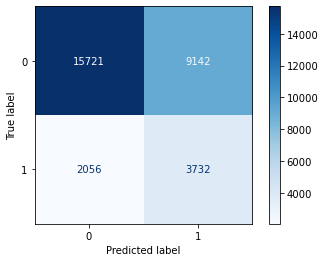

In [20]:
logistic_regression_report(X_train_us, X_test, y_train_us, y_test)


Vemos que el modelo hace un mejor trabajo en reconocer a la clase minoritaria. 

Cabe recordar que hemos descartado un gran número de observaciones (todas de la clase 0). Veamos cómo generaliza el modelo si las incluimos en el test set.

In [21]:
# Agrego los datos dropeados al test set
dropped_indices=set(loans.index)-set(undersampler.sample_indices_);

dropped_features=loans_dummy.drop(['bad_loans'],axis=1)[loans.index.isin(dropped_indices)];
dropped_targets=loans['bad_loans'][loans.index.isin(dropped_indices)];

X_test_ext=X_test.append(dropped_features)
y_test_ext=y_test.append(dropped_targets)

print('Composición del training set:')
print(y_train_us.value_counts())

print('\nComposición del test set:')
print(y_test_ext.value_counts())


Composición del training set:
1    17362
0    17362
Name: bad_loans, dtype: int64

Composición del test set:
0    96423
1    22107
Name: bad_loans, dtype: int64


              precision    recall  f1-score   support

           0       0.89      0.63      0.73     96423
           1       0.28      0.64      0.39     22107

    accuracy                           0.63    118530
   macro avg       0.58      0.64      0.56    118530
weighted avg       0.77      0.63      0.67    118530

Area bajo la curva ROC: 0.6865
Area bajo la curva Precision-Recall: 0.3226


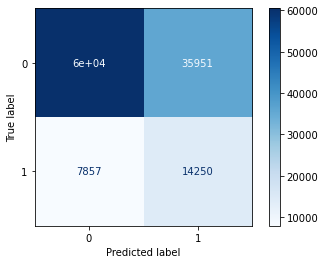

In [22]:
logistic_regression_report(X_train_us,X_test_ext,y_train_us,y_test_ext)

<a id="section_oversampling"></a>

## Oversampling

[Volver a TOC](#section_toc)



Para aumentar la representación de la clase minoritaria vamos a hacer un oversampling. Una estrategia posible es usar la herramienta RandomOversampler, que funciona de manera análoga a RandomUndersampler. En este caso, el método consiste en samplear observaciones de la clase minoritaria con reposición.

El hiperparámetro **sampling_strategy** puede tomar los valores:

* 'minority': samplea hasta balancear las clases
* número entre 0 y 1: ratio entre las clases mayoritaria y minoritaria

[Documentación](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.RandomOverSampler.html)


In [34]:
from imblearn.over_sampling import RandomOverSampler

oversampler=RandomOverSampler(sampling_strategy='minority');

X_train_os,y_train_os=oversampler.fit_resample(X_train,y_train);

print('Composición del training set:')
print(y_train_os.value_counts())

print('\nComposición del test set:')
print(y_test.value_counts())

Composición del training set:
1    74590
0    74590
Name: bad_loans, dtype: int64

Composición del test set:
0    24863
1     5788
Name: bad_loans, dtype: int64


              precision    recall  f1-score   support

           0       0.88      0.63      0.74     24863
           1       0.29      0.65      0.40      5788

    accuracy                           0.64     30651
   macro avg       0.59      0.64      0.57     30651
weighted avg       0.77      0.64      0.67     30651

Area bajo la curva ROC: 0.6888
Area bajo la curva Precision-Recall: 0.3248


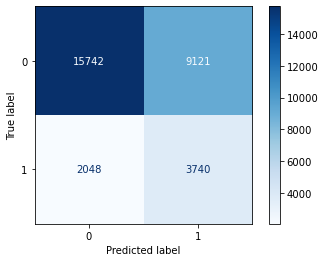

In [24]:
logistic_regression_report(X_train_os,X_test,y_train_os,y_test)

### Over sampling con SMOTE

El algoritmo SMOTE (Synthetic Minority Oversample) ofrece otra estrategia de oversampling, generando muestras simuladas de la clase minoritaria.

Cuando las features son numéricas, el algoritmo funciona de este modo:

1. Se elige un punto al azar de la clase minoritaria.
2. Se elige al azar uno de los K vecinos más cercanos al punto elegido en 1.
3. Se calcula el vector que une los puntos elegidos en 1 y 2 y se lo multiplica por un número aleatorio entre 0 y 1.
4. El punto aleatorio definido en el paso 3 constituye una nueva observación de la clase minoritaria.

De este modo, el algoritmo genera datos ficticios vecinos a las observaciones de la clase minoritaria.

Cuando las features son tanto numéricas como categóricas conviene usar la versión del algoritmo [SMOTENC](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTENC.html). Esta versión
asigna la categoría más frecuente entre los k-vecinos a la nueva instancia generada.

Hay una sutileza al respecto de usar SMOTE con variables dummy. Supongamos que convertimos las variables categóricas a dummy y luego implementamos SMOTENC tomando cada dummy como categórica, con categorías 0 y 1. El algoritmo sampleará los k vecinos más cercanos a una observación de la clase minoritaria y pontrá en cada columna dummy el valor más frecuente entre esos vecinos. Ahora bien, si la mayoría de los k vecinos (más del 50%) no es de la misma categoría, entonces el valor más frecuente en todas las dummy será el cero. De este modo estaríamos asignando erróneamente la categoría al nuevo dato generado.

Por este motivo conviene usar SMOTENC con las variables originales categóricas y luego pasar a dummy para entrenar los modelos.

In [25]:
# Volvemos a hacer el train test split (con la misma semilla que al principio) conservando las variables categóricas

X_train_cat, X_test_cat, y_train, y_test\
                            = train_test_split(loans.drop(['bad_loans'], axis=1),\
                                    loans['bad_loans'],\
                                    stratify = loans['bad_loans'],\
                                    random_state=0)

In [26]:
from imblearn.over_sampling import SMOTENC

categorical_cols=(X_train_cat.dtypes=='object').values
numerical_cols= ~categorical_cols

sm=SMOTENC(categorical_features=categorical_cols,k_neighbors=5,random_state=0)
X_train_sm,y_train_sm=sm.fit_resample(X_train_cat,y_train)

In [27]:
print('Balance de clases:')
print(y_train_sm.value_counts(normalize=False))

Balance de clases:
1    74590
0    74590
Name: bad_loans, dtype: int64


In [28]:
enc=OneHotEncoder(drop='first',sparse=False)
train_dummies=enc.fit_transform(X_train_sm.loc[:,categorical_cols])
train_dummies=pd.DataFrame(train_dummies)
train_dummies.columns=[x for cat_list in enc.categories_ for x in cat_list[1:]]

X_train_final=X_train_sm.loc[:,numerical_cols].join(train_dummies)

test_dummies=enc.transform(X_test_cat.loc[:,categorical_cols])
test_dummies=pd.DataFrame(test_dummies)
test_dummies.columns=[x for cat_list in enc.categories_ for x in cat_list[1:]]
test_dummies.index=X_test.index

X_test_final=X_test_cat.loc[:,numerical_cols].join(test_dummies)

print(X_train_final.shape)
print(X_test_final.shape)

(149180, 64)
(30651, 64)


              precision    recall  f1-score   support

           0       0.85      0.64      0.73     24863
           1       0.25      0.53      0.35      5788

    accuracy                           0.62     30651
   macro avg       0.55      0.59      0.54     30651
weighted avg       0.74      0.62      0.66     30651

Area bajo la curva ROC: 0.627
Area bajo la curva Precision-Recall: 0.2717


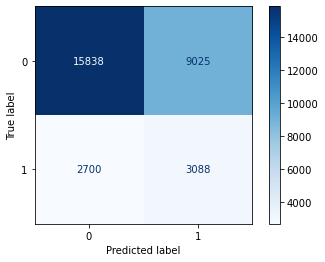

In [29]:
logistic_regression_report(X_train_final,X_test_final,y_train_sm,y_test)

<a id="section_class_weighting"></a>

## Class weighting

[Volver a TOC](#section_toc)

Otra técnica que podemos utilizar para corregir el desbalance de los datos es incorporar en la función de costos del algoritmo un mayor peso para los errores de entrenamiento cometidos sobre los puntos de la clase minoritaria. 

La regresuón logística admite el argumento "class_weight" para ponderar la contribución a la función de costo de cada clase. Si usamos class_weight = 'balanced' los pesos asignados son la inversa de la frecuencia con que se observa cada clase.


In [30]:
model = LogisticRegressionCV(class_weight = 'balanced')

scaler=StandardScaler()

X_train_sc=scaler.fit_transform(X_train);
X_test_sc=scaler.transform(X_test);

model.fit(X_train_sc,y_train)
y_pred = model.predict(X_test_sc)
pred_probas = model.predict_proba(X_test_sc);

              precision    recall  f1-score   support

           0       0.88      0.64      0.74     24863
           1       0.29      0.64      0.40      5788

    accuracy                           0.64     30651
   macro avg       0.59      0.64      0.57     30651
weighted avg       0.77      0.64      0.68     30651

Area bajo la curva ROC: 0.6866497653860503
Area bajo la curva Precision-Recall: 0.32409089241254496


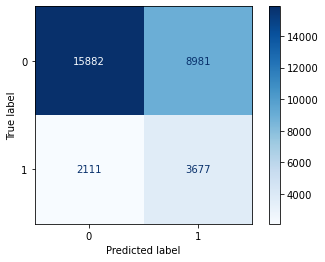

In [31]:
print(classification_report(y_test,y_pred))
plot_confusion_matrix(model,X_test_sc,y_test,cmap='Blues');

print('Area bajo la curva ROC:',roc_auc_score(y_test,pred_probas[:,1]))

precision, recall,threshold=precision_recall_curve(y_test,pred_probas[:,1]);

print('Area bajo la curva Precision-Recall:',auc(recall,precision))

Para profundizar:

https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/